# initialize

In [7]:
"""
Your first peek to MEG data with Python.
Write the path to your raw data file below!
"""
#fname="/projects/training/MNE/MNE-sample-data/MEG/sample/sample_audvis_raw.fif"
fname="/Users/simo/Documents/Data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif"

In [1]:
%matplotlib notebook
import mne
import numpy as np
import sys
import matplotlib.pyplot as plt
from mne.preprocessing import ICA

# print data info

In [9]:
raw=mne.io.read_raw_fif(fname, allow_maxshield=False, preload=True, verbose=True)
print(raw.info)

Opening raw data file /Users/simo/Documents/Data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
<Info | 25 non-empty fields
    acq_pars : unicode | 13886 items
    bads : list | MEG 2443, EEG 053
    buffer_size_sec : float64 | 0.998976065792
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (EOG: 1, EEG: 60, STIM: 9, GRAD: 204, MAG: 102)
    comps : list | 0 items
    custom_ref_applied : bool | False
    description : unicode | 49 items
    dev_head_t : Transform | 3 items
    dig : list | 146 items
    events : list | 1 items
    experimenter : unicode | 3 items
    file_id : dict | 4 items
    highpass : float | 0.10000000149 Hz
    hpi_mea

# plot raw data

<IPython.core.display.Javascript object>


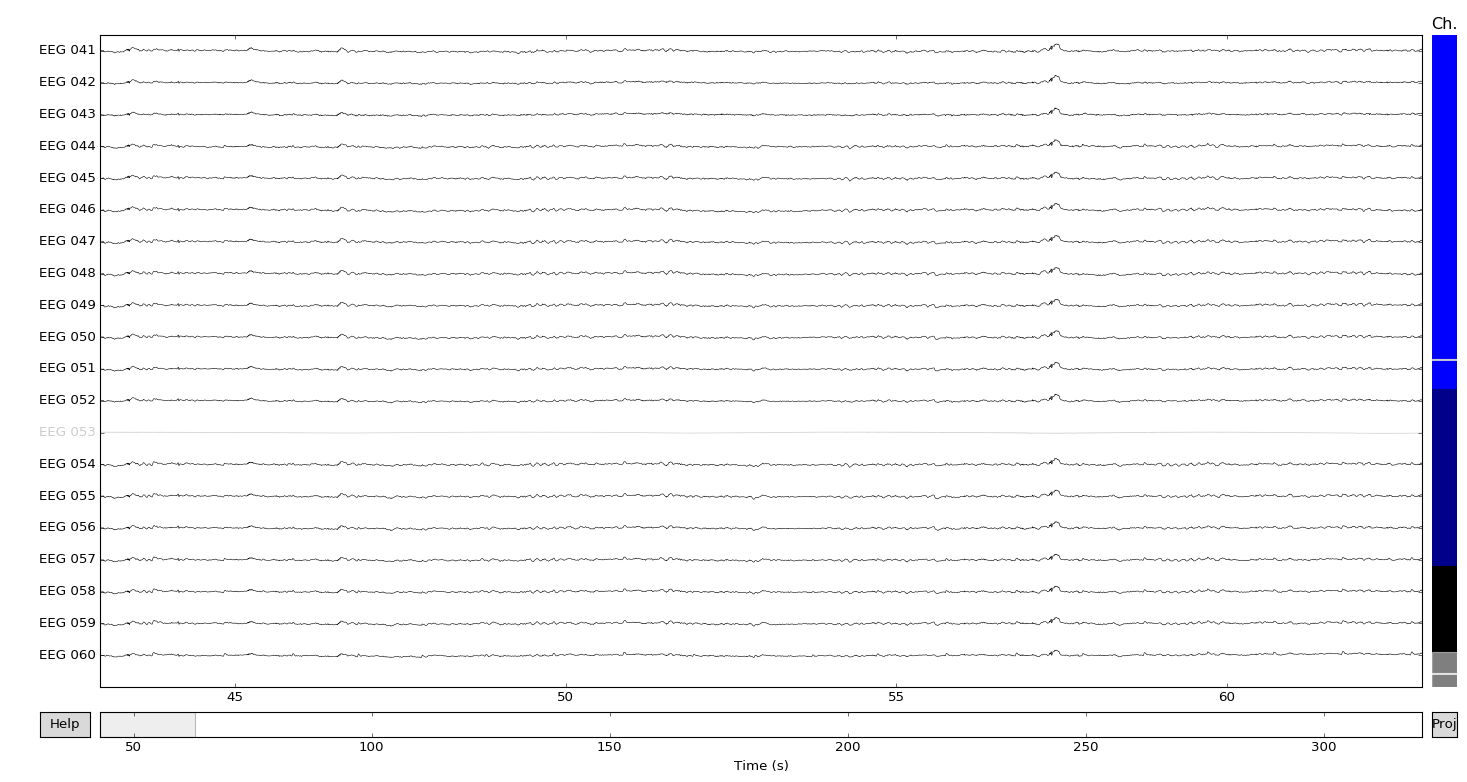

In [10]:
#R=raw.copy().crop(100,150).filter(h_freq=80, l_freq=None, filter_length='auto', fir_design='firwin', phase='zero')
# butterfly=False, group_by='selection'
raw.plot(decim='auto', show_first_samp=True, lowpass=80, scalings='auto', duration=20);

# plot spectra

<IPython.core.display.Javascript object>


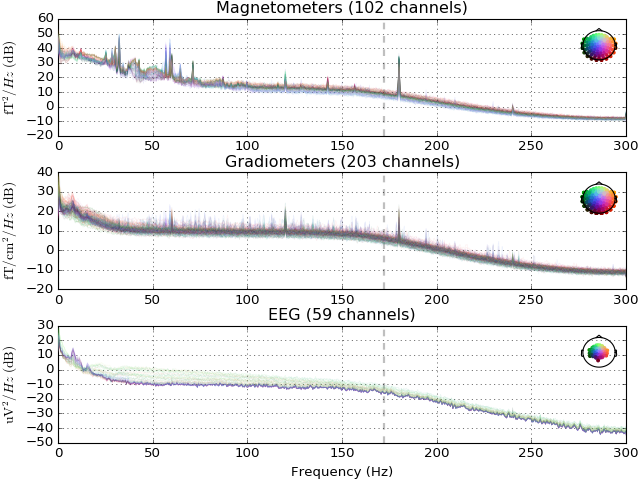

Effective window size : 3.410 (s)
Effective window size : 3.410 (s)
Effective window size : 3.410 (s)


In [11]:
raw.plot_psd(tmax=np.inf, average=False);
# OR
"""
R=raw.copy().pick_types(meg='mag')
nfft=np.int16(2*R.info['sfreq'])
R.plot_psd_topo(tmin=0, tmax=100, fmin=1, fmax=50, proj=True, n_fft=nfft, n_jobs=8, color='k',
                  fig_facecolor='w', axis_facecolor='w', layout=mne.channels.read_layout('Vectorview-mag.lout'));
R=raw.copy().pick_types(meg='grad')
R.plot_psd_topo(tmin=0, tmax=100, fmin=1, fmax=50, proj=True, n_fft=nfft, n_jobs=8, color='k',
                  fig_facecolor='w', axis_facecolor='w', layout=mne.channels.read_layout('Vectorview-grad.lout'));
""";

# run ICA for artefacts

Setting up band-pass filter from 1 - 80 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 20.0 Hz
Filter length of 1983 samples (3.302 sec) selected


[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 366 out of 366 | elapsed:    2.6s finished


Fitting ICA to data using 305 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
    Rejecting  epoch based on MAG : [u'MEG 1711']
Artifact detected in [16842, 17243]
    Rejecting  epoch based on MAG : [u'MEG 1711']
Artifact detected in [23258, 23659]
Selection by number: 40 components


<IPython.core.display.Javascript object>


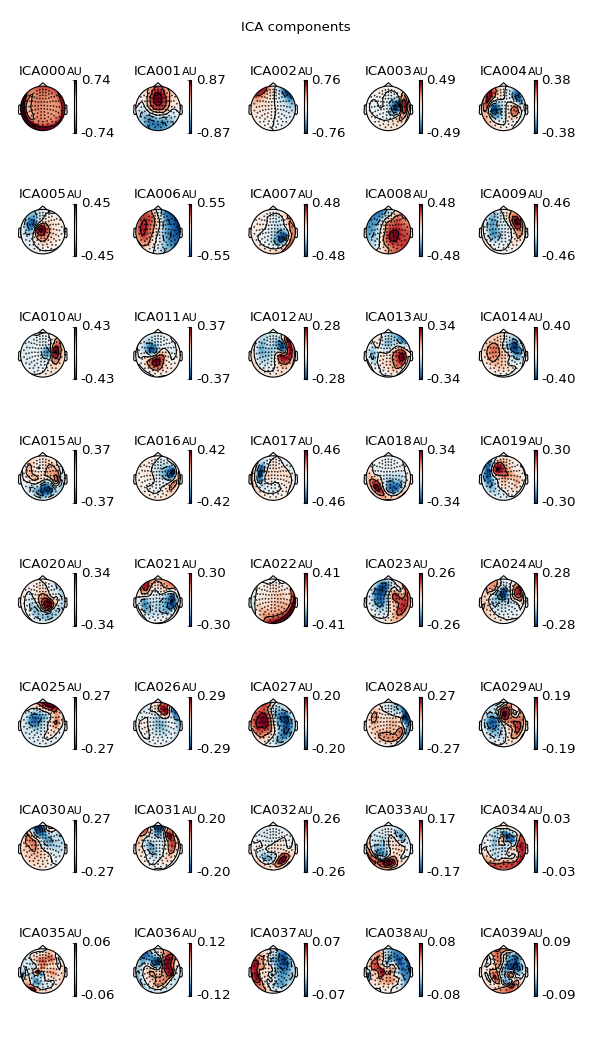

<IPython.core.display.Javascript object>


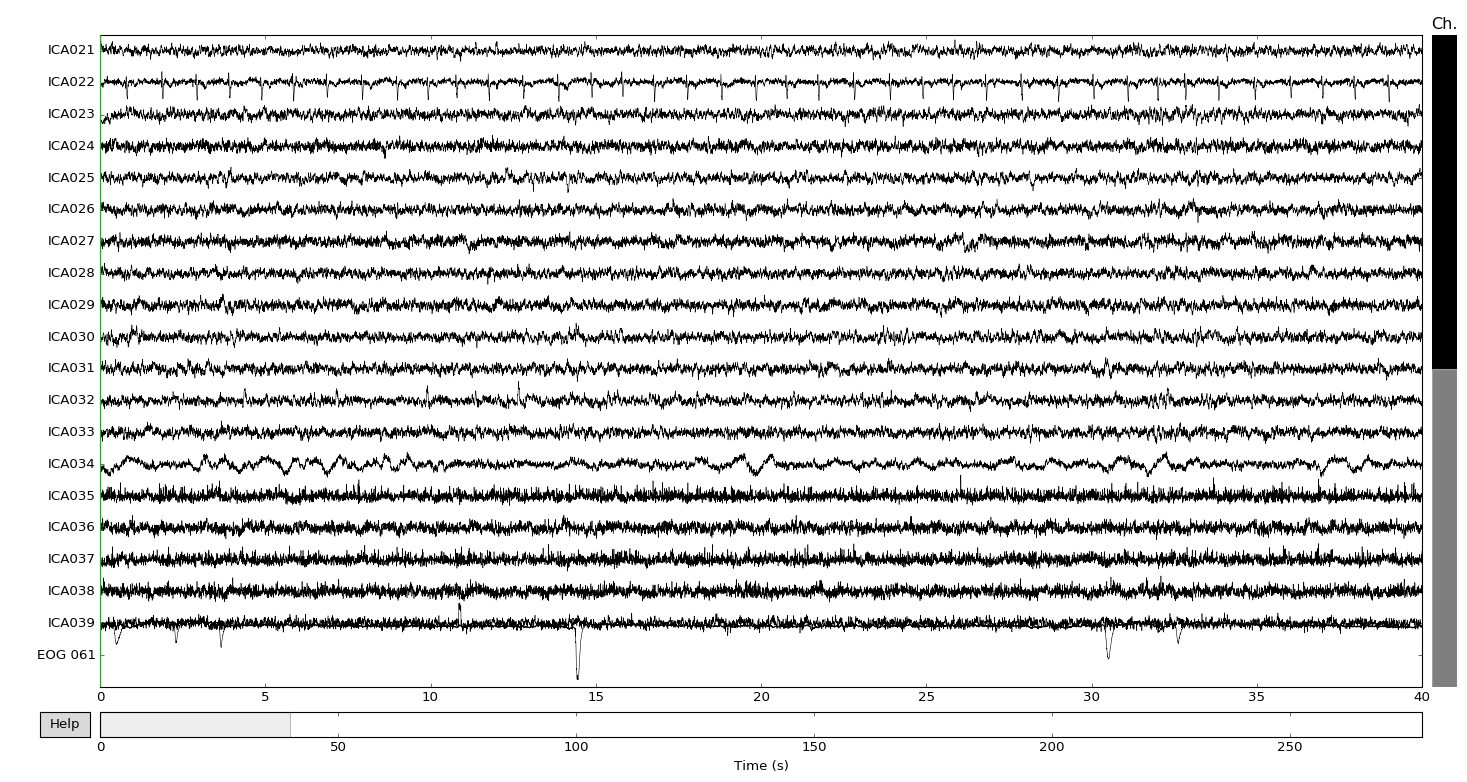

<IPython.core.display.Javascript object>


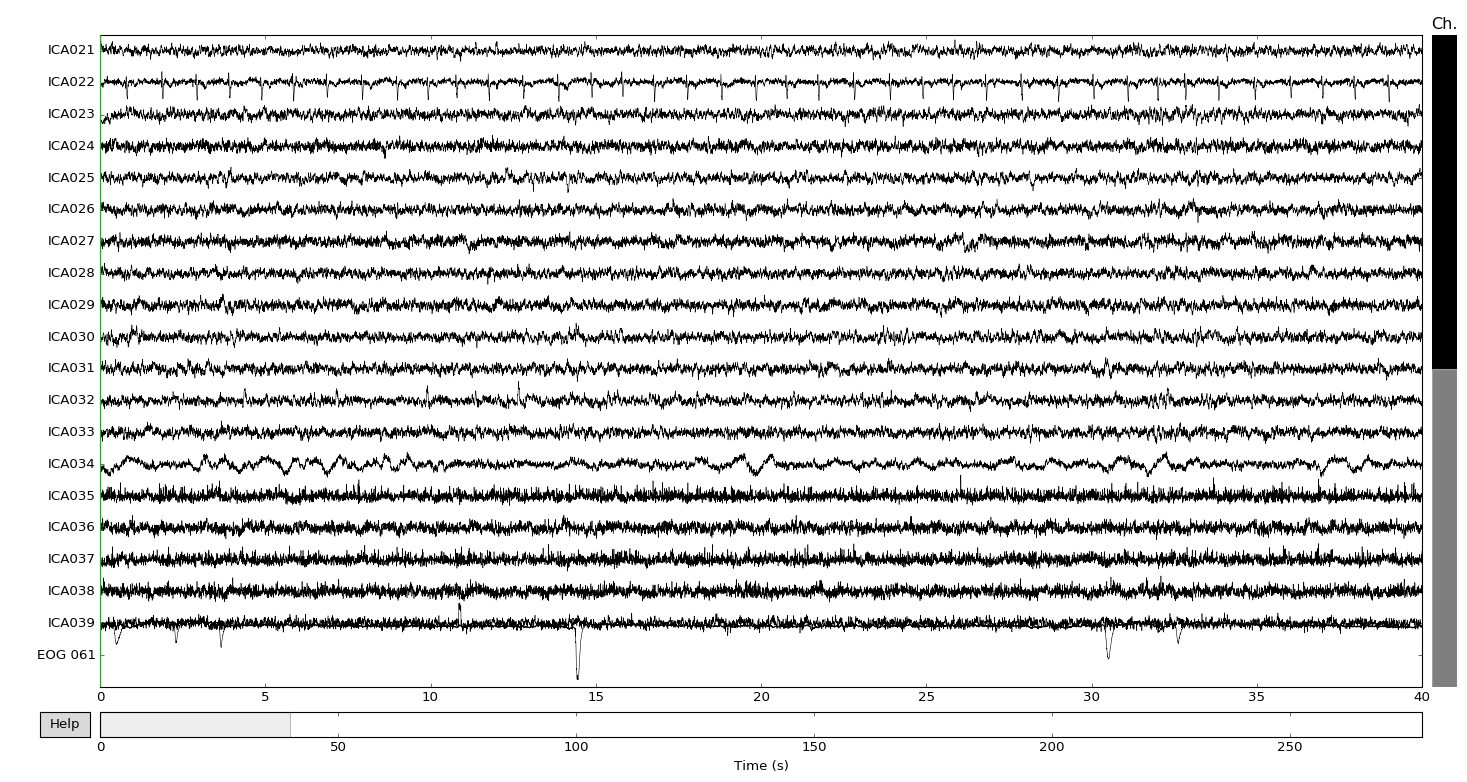

In [12]:
# Hint: click on the topomap to reveal further properties
# User parameters:
n_ica_comp=40 # can be relative (float) or absolute (int)

#from mne.preprocessing import create_eog_epochs, create_ecg_epochs?
# 1Hz high pass is often helpful for fitting ICA
# use also low-pass to possibly get neater components
np.random.seed(0)
R=raw.copy().filter(l_freq=1, h_freq=80, n_jobs=4, fir_design='firwin',
                                               filter_length='auto', phase='zero')
picks_meg = mne.pick_types(R.info, meg=True, eeg=False, eog=False, stim=False, exclude='bads')
reject_ica={'mag': 5e-12, 'grad': 5e-10}
ica = ICA(n_components=n_ica_comp, method='fastica')
ica.fit(R, picks=picks_meg, decim=3, reject=reject_ica, verbose=True)
#plt.subplot(2,1,1);
ica.plot_components(colorbar=True, image_interp='bilinear', inst=R, picks=range(ica.n_components));
#plt.close(fig1)
#plt.subplot(2,1,2);
ica.plot_sources(R, start=0, stop=ica.n_components);
#plt.show(fig2)
#plt.close(fig2)
#plt.close()

Please give the indices of components to remove: 0,2,22
Excluded components = [ 0  2 22]
Transforming to ICA space (40 components)
Zeroing out 2 ICA components
ICA applied ([ 0  2 22] components removed)
Transforming to ICA space (40 components)
Zeroing out 2 ICA components


<IPython.core.display.Javascript object>


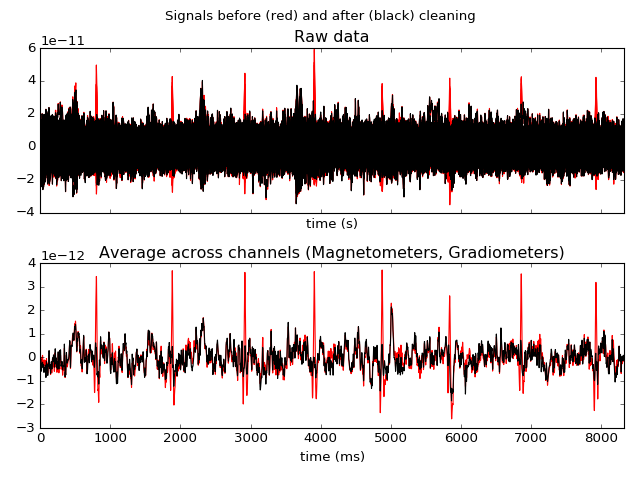

In [13]:
rm_inds=input('Please give the indices of components to remove: ')
ica.exclude = np.array(rm_inds)
#ica.exclude.extend(ica.exclude)
print('Excluded components = %s' %ica.exclude)
ica.apply(raw)
print('ICA applied (%s components removed)' %ica.exclude)
ica.plot_overlay(R, exclude=ica.exclude, stop=5000);

# find and show events

320 events found
Events id: [ 1  2  3  4  5 32]


<IPython.core.display.Javascript object>


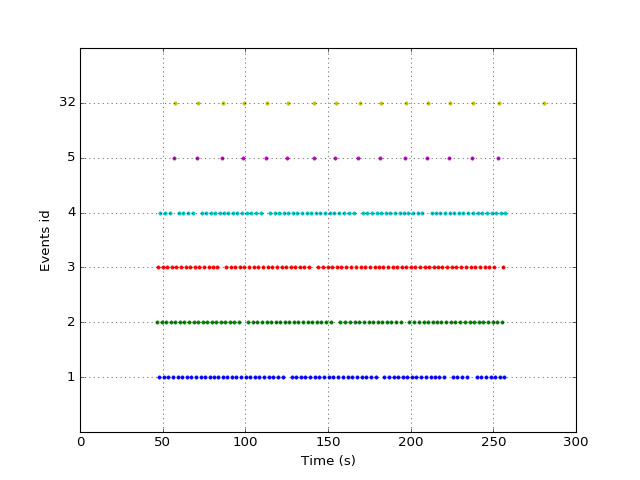

In [14]:
events=mne.find_events(raw)
mne.viz.plot_events(events, sfreq=raw.info['sfreq'], color=None);

Setting up band-pass filter from 0.5 - 40 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 7928 samples (13.200 sec) selected


<ipython-input-15-7e88b98a6dc2>:1: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  epochs=mne.Epochs(raw.filter(l_freq=0.5,h_freq=40), events, tmin=-0.2, tmax=0.5, baseline=(None,0))


320 matching events found
Created an SSP operator (subspace dimension = 3)
3 projection items activated


<IPython.core.display.Javascript object>


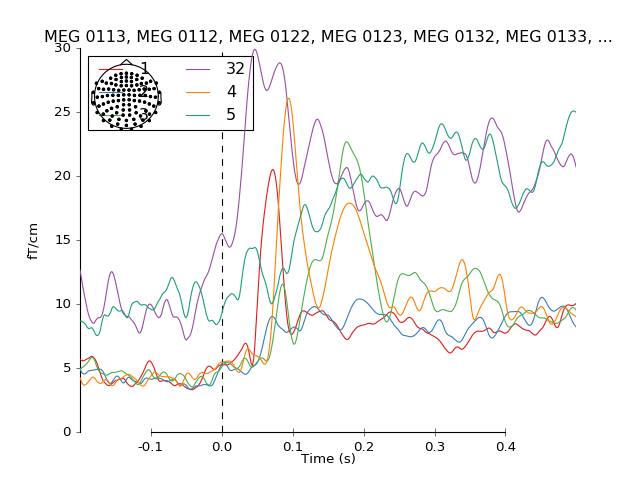

More than 6 channels, truncating title ...


<ipython-input-15-7e88b98a6dc2>:3: RuntimeWarning: More than 6 channels, truncating title ...
  mne.viz.plot_compare_evokeds(evokeds, picks=mne.pick_types(raw.info,meg='grad'));


In [15]:
epochs=mne.Epochs(raw.filter(l_freq=0.5,h_freq=40), events, tmin=-0.2, tmax=0.5, baseline=(None,0))
evokeds={str(id): epochs[str(id)].average() for id in set(events[:,2])}
mne.viz.plot_compare_evokeds(evokeds, picks=mne.pick_types(raw.info,meg='grad'));